In [1]:
"""
This script reads the worst-case perturbations produced by the script
'Demo_test_automap_stability.py' and 'Demo_test_automap_stability_knee.py',
samples these perturbations, and use the sampled perturbations as the mean for
randomly drawn gaussian noise vectors.  These noise vectors are then added to
the measurements of other images than the worst-case perturbations were
computed for.

Adjust the variables 'runner_id_automap' and 'pert_nbr', to test the knee image
"""
import os

use_gpu = False
# compute_node = 1
if use_gpu:
    # os.environ["CUDA_VISIBLE_DEVICES"]= "%d" % (compute_node)
    # print('Compute node: {}'.format(compute_node))
    os.environ["CUDA_VISIBLE_DEVICES"]= "2,3"
else: 
    os.environ["CUDA_VISIBLE_DEVICES"]= "-1"


import tensorflow as tf
import numpy as np
import h5py
import scipy.io
from os.path import join 
import os.path
from PIL import Image

from adv_tools_PNAS.automap_config import src_weights, src_data;
from adv_tools_PNAS.adversarial_tools import l2_norm_of_tensor, scale_to_01
from adv_tools_PNAS.Runner import Runner;
from adv_tools_PNAS.Automap_Runner import Automap_Runner;
from adv_tools_PNAS.RESP_automap_tools_natmod import load_runner, read_automap_k_space_mask, compile_network, hand_f, sample_image;
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import sys

runner_id_automap = 5; # Set to 12, to test the knee image perturbations
pert_nbr = 2; # Set to 0 to test the knee image perturbations
print(f'runner id: {runner_id_automap}, pert nbr: {pert_nbr}')

dest_plots = 'plots_non_zero_mean';
dest_data = 'data_non_zero_mean';
src_noise = 'data_non_zero_mean';


if not (os.path.isdir(dest_plots)):
    os.mkdir(dest_plots);
if not (os.path.isdir(dest_data)):
    os.mkdir(dest_data);

N = 128

k_mask_idx1, k_mask_idx2 = read_automap_k_space_mask();

runner = load_runner(runner_id_automap);
print(runner)
HCP_nbr = 1002



fname_data = f'automap_rID_{runner_id_automap}_random_pert.mat'
data_noise = scipy.io.loadmat(join(src_noise, fname_data))

HCP_nbr = 1002
data = loadmat(join(src_data, f'HCP_mgh_{HCP_nbr}_T2_subset_N_128.mat'));
mri_data = data['im'];
im_nbrs = [37, 50, 76];

# HCP_nbr = 1033
# data = loadmat(join(src_data, f'HCP_mgh_{HCP_nbr}_T2_subset_N_128.mat'));
# mri_data = data['im'];
# im_nbrs = [3];


batch_size = 1;
mri_data.shape[0];

sess = tf.compat.v1.Session()


raw_f, _ = compile_network(sess, batch_size)

sample = lambda im: sample_image(im, k_mask_idx1, k_mask_idx2)




/home/lfi/anaconda3/envs/danyal_tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lfi/anaconda3/envs/danyal_tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lfi/anaconda3/envs/danyal_tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lfi/anaconda3/envs/danyal_tf114

runner id: 5, pert nbr: 2

max_itr:       4
max_r_norm:    inf
max_diff_norm: inf 
la:            0.1
warm_start:    off
warm_start_factor: 0
perp_start:        rand
perp_start_factor: 1e-05
reference:         true
optimizer:         SGA
momentum:          0.9
learning_rate:     0.001
mask.shape:        (9855, 1)
len(r):            5
len(v):            5
len(x0):           1

-------------------------------
2021-06-26_te_009/2021-06-26_te_009.h5
-------------------------------
finished reading weights
<HDF5 dataset "W1_cnv": shape (5, 5, 1, 128), type "<f4">
finished test
here


In [2]:
HCP_nbr = 1002
data = loadmat(join(src_data, f'HCP_mgh_{HCP_nbr}_T2_subset_N_128.mat'));
mri_data = data['im'];
im_nbrs = [37, 50, 76];


automap_recon_arr = np.zeros(shape=(5,len(im_nbrs),128,128))
input_scale = 1/1.0
# input_scale = 1.5

# fID = open(join(dest_data, 'magnitude_e.txt'), 'w')
data_dict = {}
for r_value in range(0,5):



    e_random = data_noise[f"e{r_value}"];
    
    # print(str1)
    # fID.write(str1 + "\n")

    for i in range(len(im_nbrs)):
        im_nbr= im_nbrs[i];
        image = mri_data[im_nbr];
        image = np.expand_dims(image, 0);

        Ax = sample(image)
        
        output = raw_f((Ax+e_random)*input_scale)
        # print(output.shape)

        automap_recon_arr[r_value,i,:,:] = output

        # im_rec = np.uint8(np.squeeze(255*scale_to_01(raw_f(Ax+e_random))));

        # pil_im_rec = Image.fromarray(im_rec);
        # pil_im_rec.save(join(dest_plots, f'im_rec_rID_{runner_id_automap}_automap_HCP_{HCP_nbr}_im_nbr_{im_nbr}_random_non_zero_mean_r_idx_{r_value}.png'))

# savemat(join(dest_data, f"automap_rID_{runner_id_automap}_random_pert.mat"), data_dict);
# fID.close()



In [3]:
lasso_ims = np.zeros((4,128,128))

r_vals=[0,2,3,4]

rootpath = dest_data
for i in range(len(r_vals)):
    r_value = r_vals[i]
    lasso_data = 'im_rec_lasso_rID_5_im_nbr_76_pert_nbr_'+str(r_value)+'_rec.npy'
    lasso_fullpath = os.path.join(rootpath,lasso_data)
    lasso_ims[i,:,:] = np.load(lasso_fullpath)
    

orig_automap_array = np.load(join(dest_data,'automap_orignet_rID_5_array.npy'))

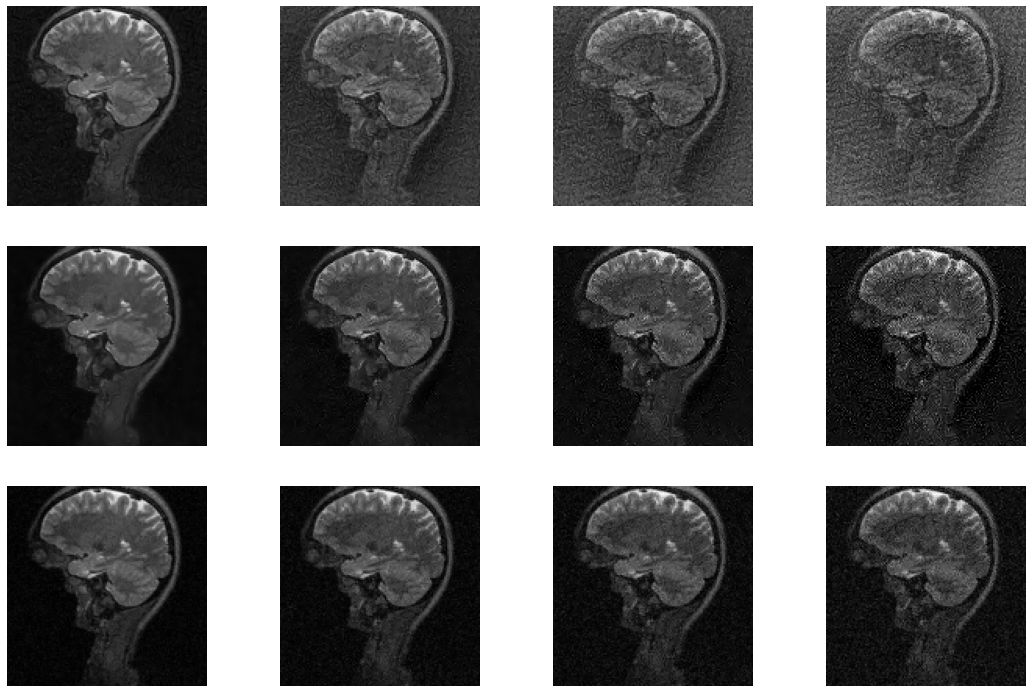

In [5]:
# FIGURE 3: Adv+Gaussian Vegard Orig vs. Retrained vs. CS

num_imgs = 4
offset = 2

fig, axs = plt.subplots(3, 4,figsize=(15*1.25,10*1.25))

r_vals=[0,2,3,4]

for i in range(num_imgs):


    r_value = r_vals[i]
    # print(axs[1,i])
    axs[0,i].imshow(orig_automap_array[r_value,2,:,:],cmap='gray')
    axs[1,i].imshow(automap_recon_arr[r_value,2,:,:],cmap='gray',vmin=-0.05,vmax=0.35)

    axs[2,i].imshow(lasso_ims[i,:,:],cmap='gray')
    
    axs[0,i].axis('off')
    axs[1,i].axis('off')
    axs[2,i].axis('off')
    # axs[1,i+1].axis('off')


    # plt.imshow(np.real(adv_noise_complex[r_value,:,:]),cmap='gray')
    # plt.colorbar()


# timesfont = {'fontfamily':'serif'}
# hfont = {'fontname':'Helvetica'}

# axs[0,0].set_title('real($e$)',fontsize=14)
# axs[0,1].set_title('real($r_1$)',fontsize=14)
# axs[0,2].set_title('real($r_2$)',fontsize=14)
# axs[0,3].set_title('real($r_3$)',fontsize=14)

# axs[1,0].set_title('imag($e$)',fontsize=14)
# axs[1,1].set_title('imag($r_1$)',fontsize=14)
# axs[1,2].set_title('imag($r_2$)',fontsize=14)
# axs[1,3].set_title('imag($r_3$)',fontsize=14)
